In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install -U ultralytics

## Importações

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import h5py
import tensorflow as tf
import cv2
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


## Crregamento dos dados
Nesta célula de código, a primeira parte é responsável por carregar os dados de um arquivo HDF5 utilizando a biblioteca h5py. O arquivo chamado 'combined_data.h5', que está armazenado no Google Drive, contém dois conjuntos de dados: X e Y. O conjunto de dados X parece representar as imagens de entrada, enquanto o conjunto Y contém as respectivas máscaras de segmentação ou labels correspondentes. Ao abrir o arquivo com h5py.File, os dados são carregados na memória nas variáveis X_data e Y_data.

## Vizualização dos dados
Em seguida, um laço for itera sobre as primeiras cinco imagens do conjunto de dados. Dentro desse laço, são criadas figuras com duas subplots para visualização das imagens. A primeira subplot mostra as imagens do conjunto X_data (que podem ser as imagens originais), enquanto a segunda subplot exibe as imagens correspondentes do conjunto Y_data (provavelmente as máscaras ou resultados esperados da segmentação). Cada imagem recebe um título indicando o índice, e a função plt.show() é chamada para exibir as figuras.

## Normalização
Depois de exibir as imagens, os dados são normalizados. As imagens em X_data e as máscaras em Y_data são divididas por 255.0 para que seus valores fiquem dentro do intervalo de 0 a 1. Essa normalização é uma prática comum no processamento de imagens, pois ajuda a estabilizar o treinamento de modelos de machine learning ao garantir que os valores estejam em uma escala adequada.

Por fim, a forma do conjunto Y_data é impressa com print(Y_data.shape), o que ajuda a verificar se o formato das máscaras é o esperado e se corresponde ao formato das imagens de entrada.

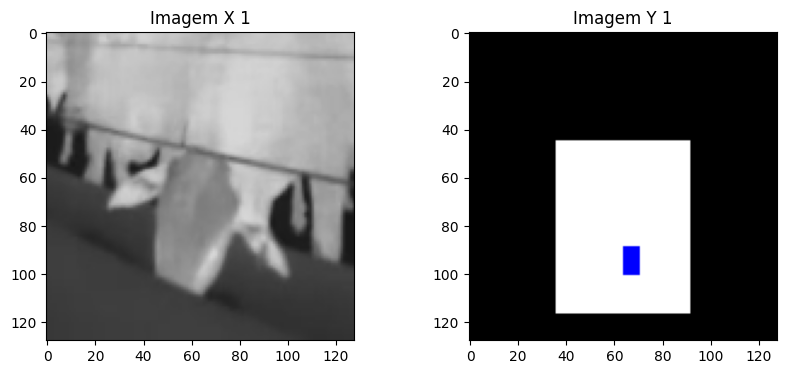

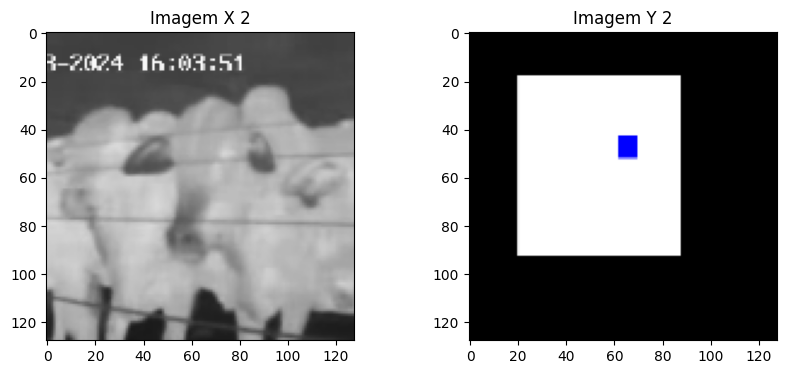

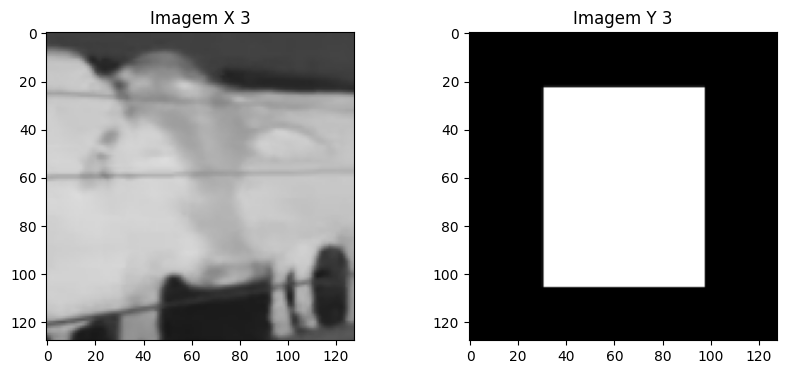

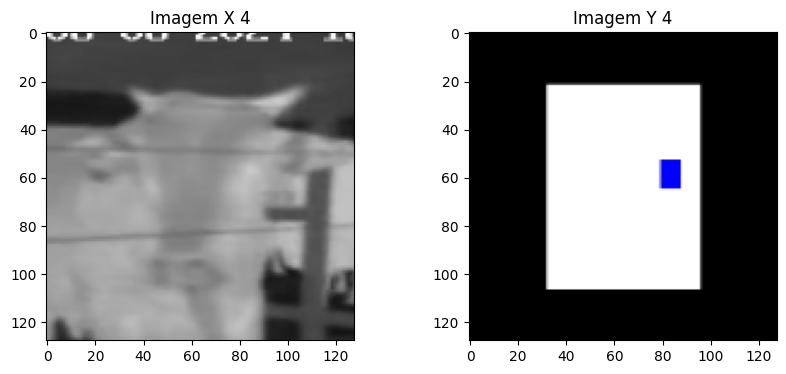

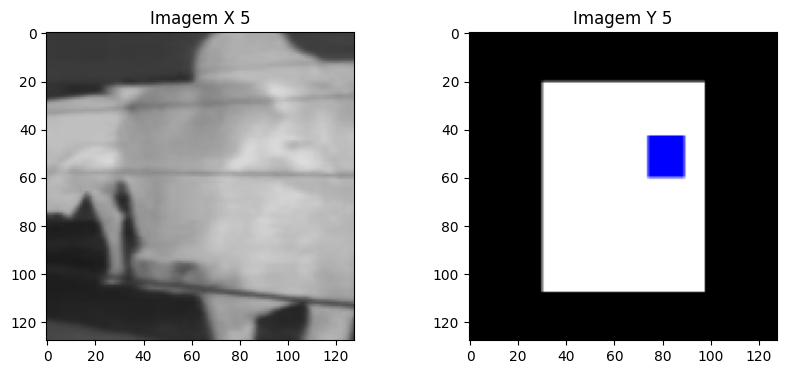

(2420, 128, 128, 3)


In [8]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/data/combined_data.h5', 'r') as h5f:
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))
    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')
    # Plotando a imagem Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data[i])
    plt.title(f'Imagem Y {i+1}')
    plt.show()

# Normalizando os dados
X_data = X_data / 255.0
Y_data = Y_data / 255.0
print(Y_data.shape)

## Manipulação das máscaras

Nesta célula, duas funções são definidas para manipular e visualizar as máscaras RGB. A função inspect_mask_channels(mask) verifica os valores únicos dos canais vermelho, verde e azul de uma máscara RGB, útil para inspecionar se os dados estão no formato correto. Já a função process_data(mask) converte uma máscara RGB em uma máscara binária, identificando a área do olho com base nos valores dos canais RGB (canal azul igual a 1, e vermelho e verde iguais a 0). As máscaras processadas são armazenadas em Y_data_processed.

Após o processamento, os dados são divididos em treino e validação, com 80% para treino e 20% para validação. Por fim, uma imagem original e sua máscara binária correspondente são exibidas para verificar visualmente o resultado do processamento.

In [9]:

# Função para inspecionar os valores dos canais RGB na máscara
def inspect_mask_channels(mask):
    if mask.ndim == 3:  # Máscara RGB
        print("Valores do Canal Vermelho (R):", np.unique(mask[:, :, 0]))
        print("Valores do Canal Verde (G):", np.unique(mask[:, :, 1]))
        print("Valores do Canal Azul (B):", np.unique(mask[:, :, 2]))
    else:
        print("A máscara não possui 3 canais (RGB).")

# Função para criar uma máscara binária para o olho a partir de uma máscara RGB
def process_data(mask):

    if mask.ndim == 3:
        eye_mask = (mask[:, :, 2] == 1.0) & (mask[:, :, 0] == 0.0) & (mask[:, :, 1] == 0.0)
        eye_mask = eye_mask.astype(np.float32)
    else:
        raise ValueError("A máscara fornecida não tem 3 canais (RGB). Verifique o formato da máscara.")

    return np.expand_dims(eye_mask, axis=-1)

# Aplicando o pré-processamento em todas as máscaras no conjunto de dados Y_data
Y_data_processed = np.array([process_data(mask) for mask in Y_data])

# Dividindo em treino e validação
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data_processed, test_size=0.2, random_state=42)


### Compilação e Treinamento do Modelo YOLOv8 para Detecção de Cabeça de Vaca



**Compilação do Modelo**: O YOLOv8, pré-treinado no modelo base yolov8s.pt, é configurado para a tarefa de detecção, utilizando o arquivo de dados data.yaml, que contém as anotações e a estrutura do conjunto de dados. O modelo é otimizado com o otimizador Adam ou SGD, e a taxa de aprendizado pode ser ajustada conforme necessário. A função de perda usada inclui a detecção de caixas delimitadoras e a classificação de objetos, adequada para identificar a cabeça de vaca nas imagens.

**Treinamento do Modelo**: O treinamento é realizado com 25 épocas, usando imagens redimensionadas para 128x128 pixels (imgsz=128). O conjunto de dados é especificado no arquivo data.yaml, que define as classes e os caminhos para as imagens e anotações. O progresso do treinamento é salvo no projeto runs/detect com o nome detect_head_cow. Durante o treinamento, o modelo ajusta suas previsões e otimiza suas capacidades de detectar cabeças de vacas nas imagens.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import xml.etree.ElementTree as ET

# Função que converte a máscara da cabeça em caixa delimitadora no formato YOLO
def mask_to_bbox(mask):
    """Converte uma máscara binária em uma caixa delimitadora no formato YOLO."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not np.any(rows) or not np.any(cols):
        return None

    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    x_center = (x_min + x_max) / 2 / mask.shape[1]  # Normalizando
    y_center = (y_min + y_max) / 2 / mask.shape[0]  # Normalizando
    width = (x_max - x_min) / mask.shape[1]  # Normalizando
    height = (y_max - y_min) / mask.shape[0]  # Normalizando

    return [x_center, y_center, width, height]

# Função para plotar a caixa delimitadora na imagem
def plot_bbox(image, bbox):
    """Plota a imagem e a caixa delimitadora."""
    x_center, y_center, width, height = bbox
    img_height, img_width = image.shape[:2]

    # Convertendo as coordenadas normalizadas para pixels
    x_min = int((x_center - width / 2) * img_width)
    x_max = int((x_center + width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    y_max = int((y_center + height / 2) * img_height)

    # Plotando a imagem e a caixa delimitadora
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    plt.show()

def process_images(frame_subfolders, frame_offsets):
    os.makedirs('datasets/images/train', exist_ok=True)
    os.makedirs('datasets/labels/train', exist_ok=True)
    os.makedirs('datasets/images/val', exist_ok=True)
    os.makedirs('datasets/labels/val', exist_ok=True)
    num_excep = 0
    for idx, subfolder_info in enumerate(frame_subfolders):
        frames_folder = subfolder_info['folder']
        xml_file = subfolder_info['xml']
        frame_offset = frame_offsets[idx]

        # Verifica se a subpasta e o arquivo XML existem
        if not os.path.exists(frames_folder) or not os.path.exists(xml_file):
            print(f"Pasta {frames_folder} ou arquivo {xml_file} não encontrado. Pulando.")
            continue

        # Parseia o arquivo XML correspondente
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Percorre todas as imagens descritas no XML
        for image_info in root.findall('.//image'):
            image_id = int(image_info.get('id'))
            frame_number = frame_offset + image_id  # Começa em 0000
            image_name = f"frame_{frame_number:04d}.png"  # Formato de 4 dígitos, começando em 0000
            image_path = os.path.join(frames_folder, image_name)

            # Verifica se a imagem existe
            if not os.path.exists(image_path):
                print(f"Imagem {image_name} não encontrada na pasta {frames_folder}. Pulando para a próxima.")
                continue

            # Carrega a imagem
            image = cv2.imread(image_path)

            # Cria uma máscara binária da cabeça
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

            # Busca as caixas da "cabeça" e "contexto"
            for box in image_info.findall('box'):
                label = box.get('label')

                if label == "cabeca":
                    cabeca_coords = (
                        int(float(box.get('xtl'))),
                        int(float(box.get('ytl'))),
                        int(float(box.get('xbr'))),
                        int(float(box.get('ybr')))
                    )
                    cv2.rectangle(mask, (cabeca_coords[0], cabeca_coords[1]), (cabeca_coords[2], cabeca_coords[3]), 255, -1)

            # Converte a máscara em bounding box no formato YOLO
            bbox = mask_to_bbox(mask)
            if bbox is None:
              num_excep += 1
            if bbox is not None:
                # Salvando a imagem na pasta de treino
                img_output_path = f'datasets/images/train/{image_name}'
                cv2.imwrite(img_output_path, image)

                # Salvando a anotação da bounding box no formato YOLO
                label_output_path = f'datasets/labels/train/{image_name.replace(".png", ".txt")}'
                with open(label_output_path, 'w') as f:
                    f.write(f"0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

            if num_excep >100:
              num_excep = 0
              break

            print(f"Processado: {image_name}, bbox: {bbox if bbox else 'Nenhuma bounding box encontrada'}")


# Definir a lista de subpastas e offsets conforme no seu código original
frame_subfolders = [
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_1', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_1.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_2', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_2.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_3', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_3.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_4', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_4.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_5', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_5.xml', 'video_code': '00000000205000000'}
]
frame_offsets = [0, 1282, 2564, 3846, 5353]

# Processar as imagens
process_images(frame_subfolders, frame_offsets)


Processado: frame_0000.png, bbox: [0.3425925925925926, 0.6347222222222222, 0.18444444444444444, 0.275]
Processado: frame_0001.png, bbox: [0.15814814814814815, 0.6453703703703704, 0.30444444444444446, 0.4351851851851852]
Processado: frame_0002.png, bbox: [0.47074074074074074, 0.4217592592592593, 0.24074074074074073, 0.5231481481481481]
Processado: frame_0003.png, bbox: [0.22555555555555556, 0.47685185185185186, 0.25555555555555554, 0.42777777777777776]
Processado: frame_0004.png, bbox: [0.29814814814814816, 0.5060185185185185, 0.5962962962962963, 0.4287037037037037]
Processado: frame_0005.png, bbox: [0.27444444444444444, 0.7699074074074074, 0.2362962962962963, 0.24537037037037038]
Processado: frame_0006.png, bbox: Nenhuma bounding box encontrada
Processado: frame_0007.png, bbox: [0.3814814814814815, 0.49537037037037035, 0.6918518518518518, 0.37222222222222223]
Processado: frame_0008.png, bbox: [0.3488888888888889, 0.5763888888888888, 0.5525925925925926, 0.3175925925925926]
Processado: f

In [11]:
import shutil

train_images_dir = '/content/datasets/images/train'
train_labels_dir = '/content/datasets/labels/train'
val_images_dir = '/content/datasets/images/val'
val_labels_dir = '/content/datasets/labels/val'

# Lista todas as imagens de treino
image_files = sorted(os.listdir('/content/datasets/images/train'))

# Separo 25% para dados de validação
num_val_images = int(len(image_files) * 0.25)

# Move 25% das imagens e seus respectivos arquivos de anotação
for i in range(num_val_images):
    image_file = image_files[i]
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')

    # Move imagem
    shutil.move(os.path.join(train_images_dir, image_file), os.path.join(val_images_dir, image_file))

    # Move label
    shutil.move(os.path.join(train_labels_dir, label_file), os.path.join(val_labels_dir, label_file))

print(f"Movidos {num_val_images} imagens e labels para a pasta de validação.")

Movidos 90 imagens e labels para a pasta de validação.


In [12]:
import yaml

# Defino os dados que serão salvos no arquivo YAML
data = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,  # Número de classes
    'names': ['head_cow']  # Lista de classes
}

# Caminho do arquivo YAML a ser criado
yaml_path = '/content/data.yaml'

# Crio e salvo o arquivo YAML
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print(f"Arquivo YAML criado em: {yaml_path}")

Arquivo YAML criado em: /content/data.yaml


In [13]:
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=25 imgsz=128 project=runs/detect name=detect_head_cow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 21.5M/21.5M [00:00<00:00, 41.6MB/s]
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=detect_head_cow, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, 

In [15]:
import pandas as pd

pd.read_csv('/content/runs/detect/detect_head_cow/results.csv')

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.8477,4.62950,2.32830,0.02207,0.07778,0.01327,0.00317,3.5637,3.8340,2.3475,0.000340,0.000340,0.000340
1,2,2.6008,2.34950,1.50390,0.13004,0.16667,0.05264,0.01503,3.5359,9.4696,2.3255,0.000672,0.000672,0.000672
2,3,1.9808,1.62580,1.21060,0.09739,0.15556,0.05509,0.01251,3.0953,12.3660,2.0096,0.000976,0.000976,0.000976
3,4,1.8978,1.46950,1.16590,0.04691,0.05556,0.01875,0.00423,3.7270,6.1440,2.6781,0.001251,0.001251,0.001251
4,5,1.7871,1.38380,1.18020,0.02985,0.04444,0.00297,0.00064,4.3304,10.8270,3.4311,0.001498,0.001498,0.001498
5,6,1.8315,1.40800,1.14290,0.03168,0.05556,0.00547,0.00108,4.3240,13.6870,2.6497,0.001604,0.001604,0.001604
6,7,1.8013,1.45110,1.15730,0.16382,0.17778,0.08103,0.02246,3.0118,2.8123,2.0736,0.001525,0.001525,0.001525
7,8,1.6470,1.24750,1.08090,0.11763,0.02222,0.02059,0.00720,3.9863,4.4872,2.4724,0.001446,0.001446,0.001446
8,9,1.6252,1.21080,1.09540,0.08478,0.05556,0.03023,0.01182,3.3904,4.0395,2.1322,0.001366,0.001366,0.001366
9,10,1.6662,1.20810,1.08160,0.40294,0.17778,0.12988,0.03513,2.9103,2.9005,1.8978,0.001287,0.001287,0.001287


### Medição de Tempo de Treinamento, Inferência

Este código mede o tempo total de treinamento do modelo e o tempo médio de inferência por imagem no conjunto de validação.


0: 128x128 1 head_cow, 9.4ms
Speed: 0.7ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 128, 128)
Tempo de Inferência: 0.1769 segundos


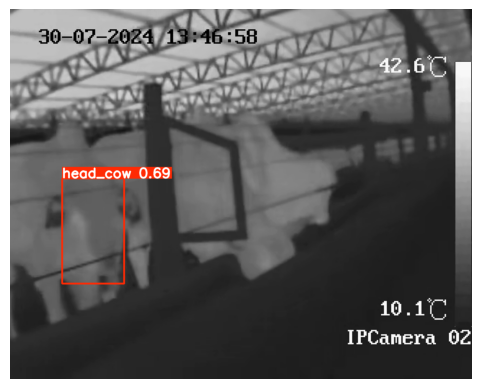

In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time  # Importa o módulo time para medir o tempo

# Carrego seu modelo treinado
model = YOLO('/content/runs/detect/detect_head_cow/weights/best.pt')

# Carrego a imagem para teste
image_path = '/content/frame_0008.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converto BGR para RGB

# Medir o tempo de inferência
start_time = time.time()  # Marca o tempo antes da predição

# Realizo a predição
results = model.predict(image)

# Marca o tempo após a predição
inference_time = time.time() - start_time
print(f"Tempo de Inferência: {inference_time:.4f} segundos")

# Exiba os resultados
for result in results:
    # Mostro a imagem com as predições
    plt.imshow(result.plot())  # Ploto a imagem com caixas delimitadoras
    plt.axis('off')
    plt.show()


## Vizualização das mascáras

Nesta célula, as primeiras cinco imagens e suas máscaras processadas são exibidas lado a lado. Para cada imagem no conjunto X_data, uma figura é criada com duas subplots: a primeira exibe a imagem original, e a segunda mostra a máscara binária correspondente, que representa a área do olho, usando uma escala de cinza. Esse processo visualiza e valida o pré-processamento realizado nas máscaras.

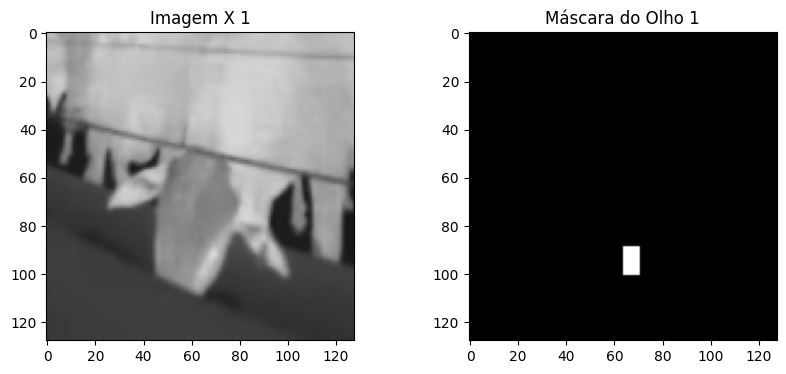

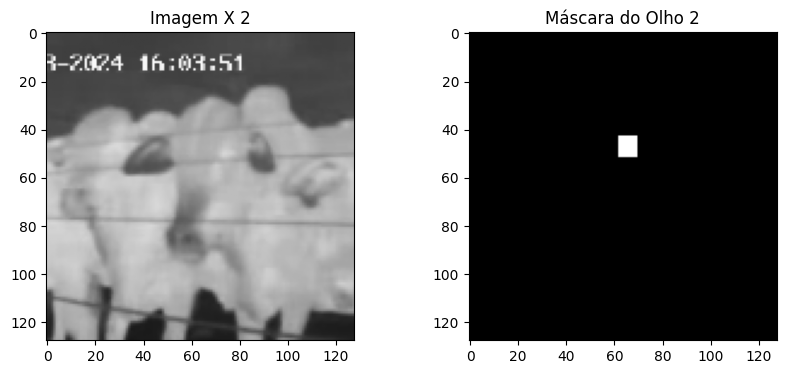

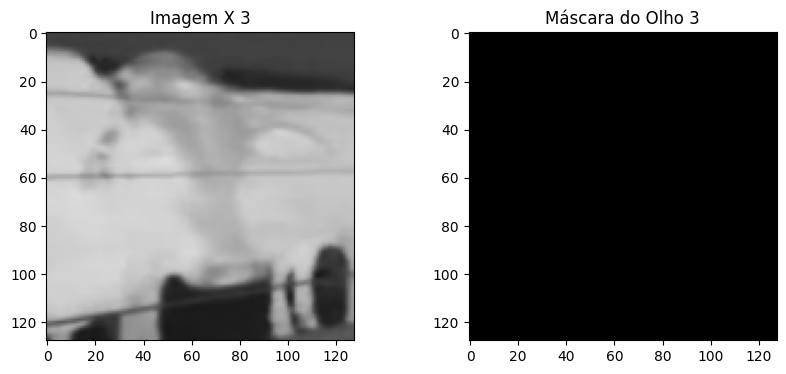

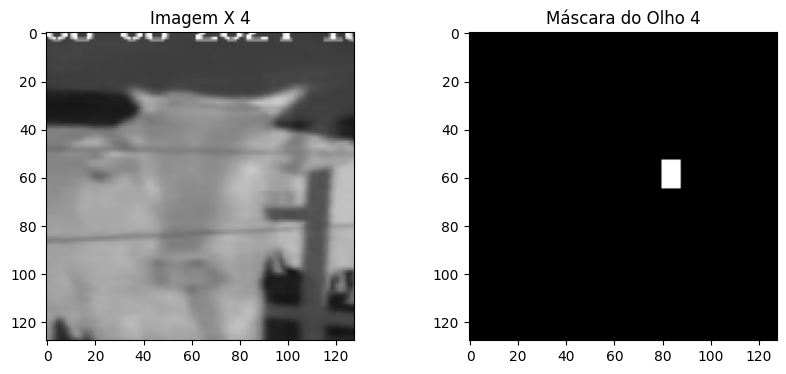

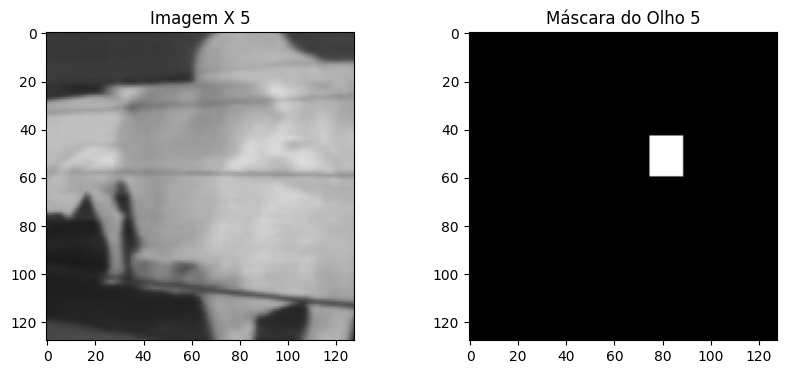

In [ ]:
for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))

    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')

    # Plotando a máscara Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data_processed[i], cmap='gray')
    plt.title(f'Máscara do Olho {i+1}')

    plt.show()

## Separação em 2 tipos de arquitetura CNN para a U-Net

- Arquitetura com Tecnicas contra overfitting
  - Reguralização
  - Dropout
  - Early stopping

- Arquitetura "original"



### Função conv_block

Essa função, chamada conv_block, implementa um bloco de convolução padrão utilizado em redes neurais convolucionais. Ela recebe dois parâmetros: inputs, que é a entrada para o bloco, e filterCount, que define o número de filtros nas camadas convolucionais.

O bloco consiste em duas camadas convolucionais seguidas de normalização em batch (BatchNormalization), que ajuda a estabilizar e acelerar o treinamento, e uma função de ativação ReLU, que introduz não linearidade. Ambas as convoluções utilizam filtros 3x3 com padding "same", o que mantém as dimensões espaciais da entrada. Esse bloco é uma construção básica para extrair características das imagens de entrada.

No final, a saída x, após as duas operações convolucionais e ativações, é retornada para ser usada nas camadas subsequentes da rede.

In [ ]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

### Função conv_block_nor
Essa função, chamada conv_block_nor, implementa um bloco convolucional com regularização L2 e dropout, além da normalização em batch e a ativação ReLU.

Ela recebe dois parâmetros: inputs, que são os dados de entrada, e filter_count, que define a quantidade de filtros nas camadas convolucionais. O bloco realiza o seguinte:

Aplica uma camada convolucional com filtros 3x3, onde é adicionada regularização L2 para evitar overfitting.
Utiliza a normalização em batch para estabilizar o treinamento.
Aplica a função de ativação ReLU, que adiciona não linearidade.
Aplica dropout com uma taxa de 0.6 para reduzir overfitting, desativando aleatoriamente 60% dos neurônios durante o treinamento.
Esses passos são repetidos duas vezes, retornando a saída final, que será usada nas camadas seguintes da rede. Esse bloco combina regularização e dropout para melhorar a robustez do modelo.

In [ ]:

def conv_block_nor(inputs, filter_count):
    x = Conv2D(filter_count, 3, padding="same", kernel_regularizer=l2(1e-4))(inputs)  # Regularização L2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.6)(x)  # Dropout de 0.6

    x = Conv2D(filter_count, 3, padding="same", kernel_regularizer=l2(1e-4))(x)  # Regularização L2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.6)(x)  # Dropout de 0.6
    return x

### Função decoder_block

A função decoder_block é responsável por realizar a decodificação na rede, especialmente em arquiteturas como a U-Net, onde a ideia é recuperar as dimensões originais da imagem ao longo do caminho de saída. Ela recebe três parâmetros: inputs, que são os dados da camada anterior; skip_features, que correspondem às conexões de atalho (skip connections) da fase de codificação; e filter_count, que define a quantidade de filtros para as camadas convolucionais.

Primeiramente, a função utiliza a camada Conv2DTranspose, que é uma convolução transposta, para aumentar a resolução espacial das entradas, realizando um upsampling, ou seja, dobrando a resolução da imagem. Em seguida, os resultados da convolução transposta são concatenados com as skip_features da parte correspondente do encoder. Essa concatenação permite que detalhes perdidos durante a redução de dimensionalidade sejam recuperados, utilizando informações detalhadas armazenadas na fase de codificação.

Por fim, o bloco convolucional conv_block é chamado para processar o resultado combinado, aplicando duas camadas convolucionais que refinam a informação e preparam a saída final do bloco. O objetivo desse bloco é, portanto, restaurar a resolução da imagem ao mesmo tempo em que aproveita as informações detalhadas da fase de codificação para melhorar a precisão da segmentação.

In [ ]:
def decoder_block(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

### Função decoder_block_nor

A função decoder_block_nor é uma versão modificada de um bloco de decodificação que incorpora regularização e dropout durante o processo de reconstrução da imagem. Ela recebe três parâmetros: inputs, que são as saídas da camada anterior; skip_features, que são as conexões de atalho da fase de codificação; e filter_count, que define o número de filtros a serem aplicados nas camadas convolucionais.

Primeiro, a função aplica uma convolução transposta (Conv2DTranspose) para aumentar a resolução espacial da entrada, dobrando as dimensões da imagem. Isso ajuda a reverter a redução de dimensionalidade que ocorre durante a fase de codificação. Em seguida, as saídas dessa camada são concatenadas (Concatenate) com as skip_features, que trazem informações detalhadas da parte de codificação para melhorar a reconstrução dos detalhes finos da imagem.

Depois de concatenar, o código chama a função conv_block_nor, que aplica dois blocos convolucionais com regularização L2 e dropout. Isso é feito para melhorar a generalização do modelo e evitar overfitting, além de estabilizar o treinamento. Ao final, a saída resultante é retornada, já processada e com a resolução restaurada, mantendo as informações detalhadas vindas da fase de codificação.

In [ ]:
def decoder_block_nor(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_nor(x, filter_count)
    return x

### Função unet_vgg16
A função unet_vgg16 implementa uma arquitetura U-Net utilizando o modelo pré-treinado VGG16 como o encoder, aproveitando as camadas convolucionais desse modelo para extração de características.

O modelo começa com as entradas definidas pelo parâmetro input_shape. O VGG16 é carregado sem a camada de classificação final (include_top=False) e com pesos pré-treinados na ImageNet. As saídas intermediárias de várias camadas do VGG16, chamadas skip1 a skip4, são armazenadas para serem reutilizadas no processo de decodificação (essas são as "skip connections" que ajudam a preservar detalhes da imagem).

A partir da camada central (extraída da última camada convolucional do VGG16), o modelo começa a fase de decodificação, onde as dimensões espaciais são gradualmente restauradas através de blocos de decodificação (decoder_block), usando as informações das skip connections. O processo de decodificação é aplicado em quatro níveis, cada um restaurando uma parte da resolução da imagem.

No final, uma camada convolucional com um filtro de tamanho 1x1 e ativação "sigmoid" gera a saída da U-Net, que tem um único canal, representando uma máscara binária para segmentação.

Esse modelo é projetado para segmentar objetos em imagens aproveitando a arquitetura profunda do VGG16 para a extração de características e a estrutura U-Net para a reconstrução da máscara de segmentação.


In [ ]:
def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

    # Encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    # Centro
    center = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    # Saída com 1 canal (máscara binária)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

### Função unet_vgg16_nor

A função unet_vgg16_nor é uma variação do modelo U-Net que utiliza o VGG16 como encoder, porém com regularização L2 e dropout aplicados nas camadas do decodificador, através do uso da função decoder_block_nor.

Assim como na versão anterior, o modelo começa carregando o VGG16 sem a camada final de classificação (include_top=False), utilizando os pesos pré-treinados na ImageNet. As saídas de camadas intermediárias (skip1 a skip4) são armazenadas para uso no decodificador.

Na fase de decodificação, ao invés de usar o decoder_block simples, o código usa decoder_block_nor, que inclui regularização L2 e dropout, o que ajuda a melhorar a generalização do modelo e a mitigar o overfitting. Esse processo é feito em quatro níveis de decodificação, restaurando as dimensões da imagem enquanto incorpora informações detalhadas do encoder.

No final, a saída é uma máscara binária gerada por uma camada convolucional com um único filtro 1x1 e ativação "sigmoid", representando a área segmentada da imagem.

Essa versão do modelo é mais robusta contra overfitting, graças à inclusão de técnicas de regularização durante o processo de decodificação.

In [ ]:
def unet_vgg16_nor(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

    # Encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    # Centro
    center = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = decoder_block_nor(center,skip4,512)
    d2 = decoder_block_nor(d1,skip3,256)
    d3 = decoder_block_nor(d2,skip2,128)
    d4 = decoder_block_nor(d3,skip1,64)

    # Saída com 1 canal (máscara binária)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

### input_shape e declaração das arquiteturas dos modelos

Aqui, duas instâncias de modelos U-Net com base no VGG16 são criadas, ambos com uma entrada de imagens de formato (128, 128, 3) (imagens RGB de 128x128 pixels).

O primeiro modelo, model, é gerado pela função unet_vgg16(input_shape), que utiliza a versão padrão do U-Net com VGG16 como encoder, sem regularização adicional no decodificador.

O segundo modelo, model2, é criado pela função unet_vgg16_nor(input_shape), que aplica regularização L2 e dropout nos blocos de decodificação, tornando-o mais robusto contra overfitting.

Ambos os modelos estão prontos para serem treinados em tarefas de segmentação, sendo o model2 mais adequado para cenários onde o risco de overfitting é maior.

In [ ]:
input_shape = (128,128,3)
model = unet_vgg16(input_shape)
model2 = unet_vgg16_nor(input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Função de perda

Esse código define a função de perda Dice Loss, que é frequentemente usada em tarefas de segmentação, especialmente quando se trabalha com dados que possuem desequilíbrio de classes. A função mede a sobreposição entre as previsões do modelo (y_pred) e os valores reais (y_true), ajudando a maximizar a precisão da segmentação de regiões específicas.

In [ ]:

# Define the Dice Loss function
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


### Compilação e Treinamento do modelo

Aqui o modelo U-Net é compilado e treinado para a tarefa de segmentação.

Compilação do Modelo: O modelo é compilado utilizando o otimizador Adam com uma taxa de aprendizado definida como 1e-3. A função de perda usada é a Dice Loss, que é ideal para tarefas de segmentação, e a métrica utilizada para monitoramento é a acurácia ("accuracy"). A Dice Loss ajuda a avaliar a sobreposição entre as previsões do modelo e as máscaras reais.

Treinamento do Modelo: O modelo é treinado utilizando o conjunto de dados de treino (X_train e Y_train) com 50 épocas. O parâmetro steps_per_epoch define quantos lotes (batches) de 32 imagens são processados por época. A validação é feita ao final de cada época utilizando o conjunto de validação (X_val e Y_val), o que permite monitorar a performance do modelo ao longo do treinamento.

Avaliação do Modelo: Após o treinamento, o modelo é avaliado no conjunto de validação usando a função model.evaluate. Isso fornece uma visão geral de quão bem o modelo generaliza, calculando a perda (Dice Loss) e a acurácia no conjunto de validação.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=["accuracy"])


# Treinando o modelo
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    )
# Avaliação do modelo
model.evaluate(X_val, Y_val)

Epoch 1/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7212 - loss: 0.9214

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 421ms/step - accuracy: 0.7234 - loss: 0.9204 - val_accuracy: 0.0213 - val_loss: 0.9771
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9818 - loss: 0.6546 - val_accuracy: 0.6991 - val_loss: 0.9439
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9867 - loss: 0.5376 - val_accuracy: 0.9176 - val_loss: 0.8331
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9876 - loss: 0.5100 - val_accuracy: 0.8716 - val_loss: 0.8756
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9879 - loss: 0.4954 - val_accuracy: 0.9895 - val_loss: 0.5441
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9883 - loss: 0.4812 - val_accuracy: 0.9837 - val_loss: 0.6243
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9890 - loss: 0.4680 - val_accuracy: 0.9789 - val_loss: 0.5755
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9885 - loss: 0.4668 - val_accuracy: 0.9887 - val_loss: 

[0.47824981808662415, 0.9907448291778564]

### Utilização de data augmentation
Neste código, o Data Augmentation é configurado para aumentar a diversidade dos dados de treino, aplicando transformações como rotações, deslocamentos, zoom, flips horizontais, e cisalhamento nas imagens. Essas técnicas ajudam a prevenir overfitting ao gerar variações nas imagens de cada batch de treino, sem aumentar o tamanho do dataset. Para o conjunto de validação, as imagens são geradas sem qualquer alteração. Dois geradores, um para o treino e outro para a validação, são configurados para fornecer batches de 32 imagens e suas respectivas máscaras durante o treinamento.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Definindo um Data Augmentation
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     shear_range=0.2,
                     fill_mode='nearest')

# Aumentar a diversidade dos dados pode ajudar a prevenir overfitting
train_datagen = ImageDataGenerator(**data_gen_args)

# Gera dados para o conjunto de validação, sem aplicar Data Augmentation.
val_datagen = ImageDataGenerator()

# Gera batches de imagens e máscaras para o treino, com augmentação aplicada.
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

# Gera batches de imagens e máscaras para a validação, sem augmentação.
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

### Compilando segundo modelo e treinando

Neste código, o segundo modelo U-Net (model2) é compilado com uma taxa de aprendizado inicial menor (1e-4), visando ajustes mais finos durante o treinamento. A função de perda usada é a Dice Loss, e a métrica monitorada é a acurácia.

Foram definidos dois callbacks para melhorar a eficiência do treinamento:

EarlyStopping com paciência reduzida para 10 épocas sem melhora, para evitar que o modelo continue treinando desnecessariamente, além de restaurar os melhores pesos.
ReduceLROnPlateau, que monitora a perda de validação e reduz a taxa de aprendizado em 10 vezes (fator de 0.1) se a perda não melhorar após 5 épocas consecutivas, evitando overfitting e permitindo ajustes mais finos nos últimos estágios do treinamento.
O modelo é treinado usando o gerador de dados com 50 épocas, e os callbacks garantem que o treinamento seja ajustado conforme o progresso. Após o treinamento, o modelo é avaliado no conjunto de validação para medir o desempenho final.

In [ ]:

# Compilando o modelo com uma taxa de aprendizado inicial menor
model2.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

# Callbacks ajustados
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),  # Reduzindo patience para 5
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),  # Fator de redução mais agressivo
]

# Treinando o modelo com o gerador de dados
history2 = model2.fit(train_generator,
                      validation_data=val_generator,
                      steps_per_epoch=len(X_train) // 32,
                      epochs=50,
                      callbacks=callbacks)

# Avaliação do modelo
model2.evaluate(X_val, Y_val)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 320ms/step - accuracy: 0.9381 - loss: 0.8813 - val_accuracy: 0.9219 - val_loss: 0.8946 - learning_rate: 1.0000e-04
Epoch 2/50
 1/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9369 - loss: 0.8559

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9369 - loss: 0.8559 - val_accuracy: 0.9266 - val_loss: 0.8917 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.9419 - loss: 0.8750 - val_accuracy: 0.9824 - val_loss: 0.8732 - learning_rate: 1.0000e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9471 - loss: 0.8286 - val_accuracy: 0.9872 - val_loss: 0.9419 - learning_rate: 1.0000e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9426 - loss: 0.8687 - val_accuracy: 0.9601 - val_loss: 0.8605 - learning_rate: 1.0000e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9510 - loss: 0.8215 - val_accuracy: 0.9579 - val_loss: 0.8698 - learning_rate: 1.0000e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9494 - loss: 0.8612 - val_accuracy: 0.4719 - val_loss: 0.9794 - learning_rate: 1.0000e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9499 - loss: 0.84

[0.7903949618339539, 0.9557967782020569]

## Visualização e comparação dos dois modelos


Esta função compara visualmente as segmentações geradas por dois modelos diferentes para uma mesma imagem. Ela exibe a imagem original, a máscara verdadeira, e as predições feitas por ambos os modelos, permitindo avaliar visualmente as diferenças no desempenho entre eles.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


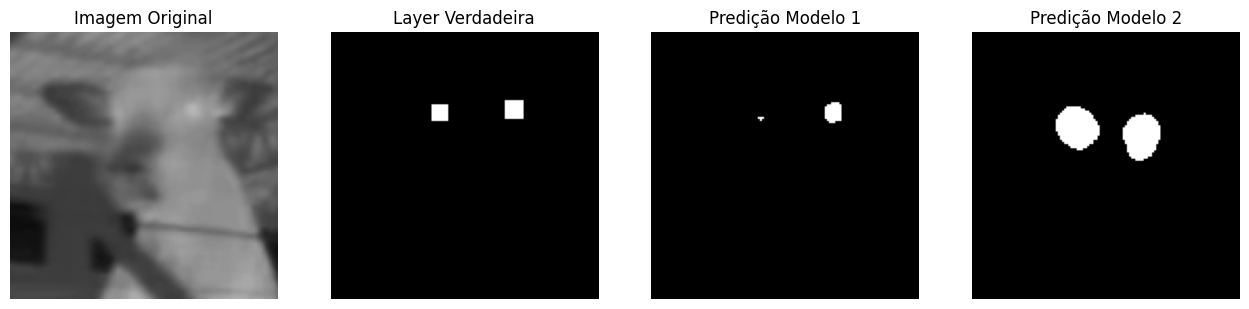

In [ ]:

# Exibindo a comparação das segmentações de uma imagem entre dois modelos
def plot_prediction_comparison(model1, model2, X, Y, index):

    # Predição com o primeiro modelo
    pred1 = model1.predict(np.expand_dims(X[index], axis=0))
    pred1 = (pred1 > 0.5).astype(np.uint8)  # Binarizando a predição

    # Predição com o segundo modelo
    pred2 = model2.predict(np.expand_dims(X[index], axis=0))
    pred2 = (pred2 > 0.5).astype(np.uint8)  # Binarizando a predição

    plt.figure(figsize=(20, 5))

    # Imagem Original
    plt.subplot(1, 5, 1)
    plt.imshow(X[index])
    plt.title('Imagem Original')
    plt.axis('off')

    # Layer Verdadeira
    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(Y[index]), cmap='gray')
    plt.title('Layer Verdadeira')
    plt.axis('off')

    # Predição Modelo 1
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(pred1), cmap='gray')
    plt.title('Predição Modelo 1')
    plt.axis('off')

    # Predição Modelo 2
    plt.subplot(1, 5, 4)
    plt.imshow(np.squeeze(pred2), cmap='gray')
    plt.title('Predição Modelo 2')
    plt.axis('off')


    plt.show()

# Exemplo de predição
plot_prediction_comparison(model, model2, X_val, Y_val, index=10)

## Demonstração dos resultados:

Nesta célula, comparamos os resultados de dois modelos: o "modelo original" e o "modelo com técnicas de combate ao overfitting". Ambos os modelos são visualizados através de gráficos de acurácia e perda ao longo das épocas de treinamento e validação.

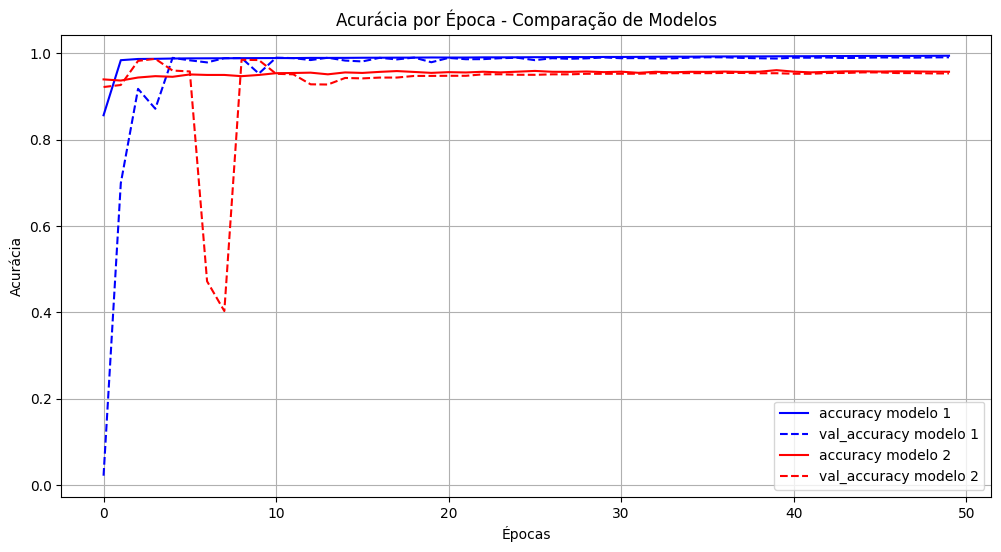

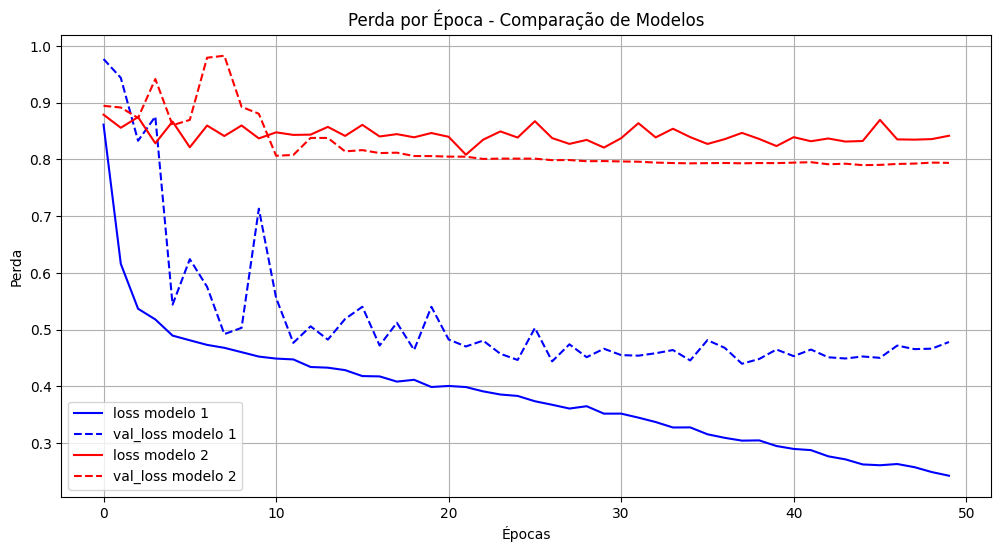

In [ ]:

# Função para plotar os gráficos de acurácia e perda de dois modelos
def plot_accuracy_loss(history1, history2):

    # Gráfico de Acurácia
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['accuracy'], label='accuracy modelo 1', color='blue')
    plt.plot(history1.history['val_accuracy'], label='val_accuracy modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['accuracy'], label='accuracy modelo 2', color='red')
    plt.plot(history2.history['val_accuracy'], label='val_accuracy modelo 2', color='red', linestyle='dashed')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title('Acurácia por Época - Comparação de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de Perda
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['loss'], label='loss modelo 1', color='blue')
    plt.plot(history1.history['val_loss'], label='val_loss modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['loss'], label='loss modelo 2', color='red')
    plt.plot(history2.history['val_loss'], label='val_loss modelo 2', color='red', linestyle='dashed')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.title('Perda por Época - Comparação de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_loss(history, history2)



### Função de perda do primeiro modelo / treinamento e validação

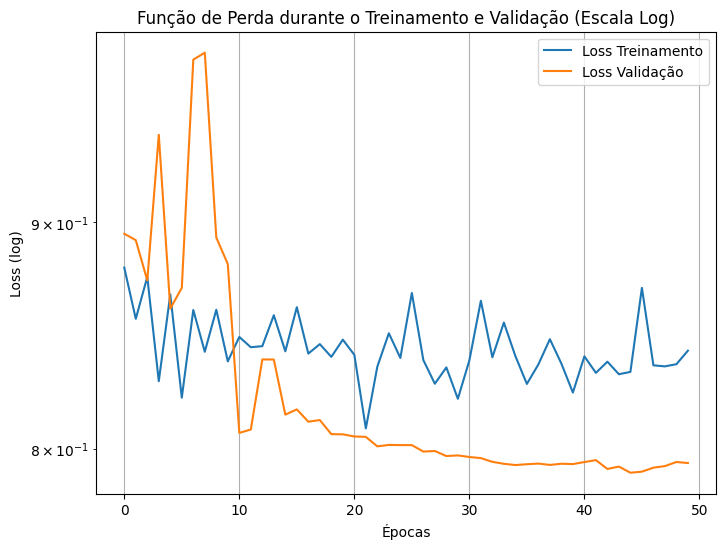

In [ ]:
# Função para plotar o gráfico de perda (loss)
def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Plotando a perda no treinamento
    plt.plot(history.history['loss'], label='Loss Treinamento')

    # Plotando a perda na validação
    plt.plot(history.history['val_loss'], label='Loss Validação')

    # Configurações do gráfico
    plt.title('Função de Perda durante o Treinamento e Validação (Escala Log)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (log)')
    plt.yscale('log')  # Definir o eixo y como logarítmico
    plt.legend(loc='upper right')
    plt.grid(True)

    # Mostrando o gráfico
    plt.show()

# Gerando o gráfico de perda
plot_loss(history2)


### Função para plotar imagem original, máscara real e previsão do primeiro modelo

### Visualização da Máscara de Segmentação Predita Sobreposta à Imagem Original com Transparência

Este código define uma função que sobrepõe uma máscara de segmentação predita sobre uma imagem original, utilizando transparência para destacar as áreas segmentadas. A função, chamada overlay_mask_on_image, recebe como parâmetros a imagem original, a máscara predita binária e um valor de transparência (alpha). A máscara é redimensionada para ter três canais (RGB) e aplicada na imagem original, com as áreas segmentadas destacadas em vermelho. A imagem resultante é uma combinação da imagem original e da máscara predita com transparência, facilitando a visualização do desempenho do modelo.

Após a definição da função, o código gera previsões de máscara sobre o conjunto de validação e, para cada imagem em um intervalo de 10 imagens, aplica a função de sobreposição, exibindo o resultado final.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


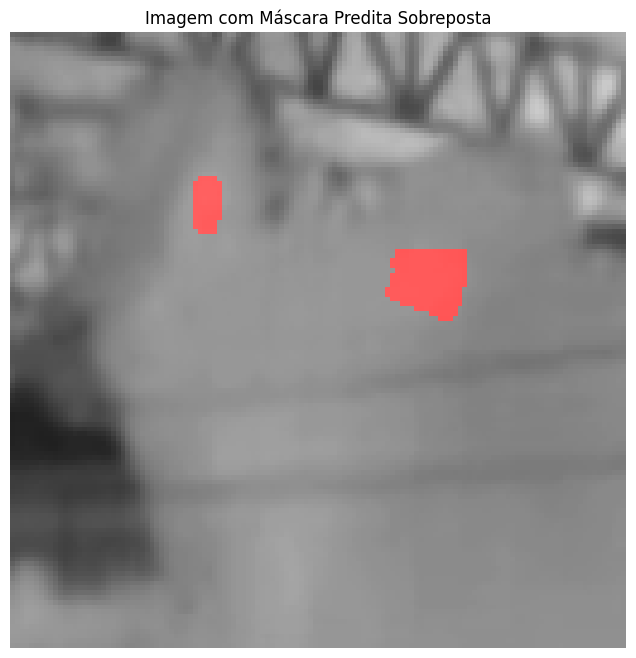

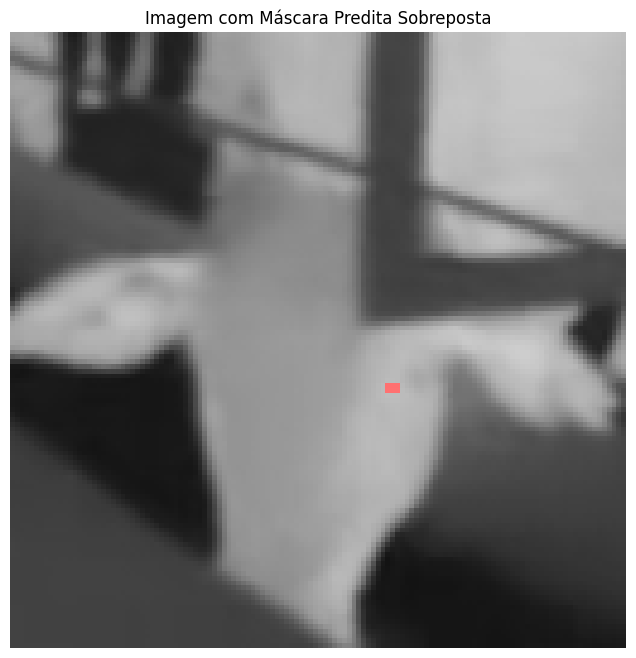

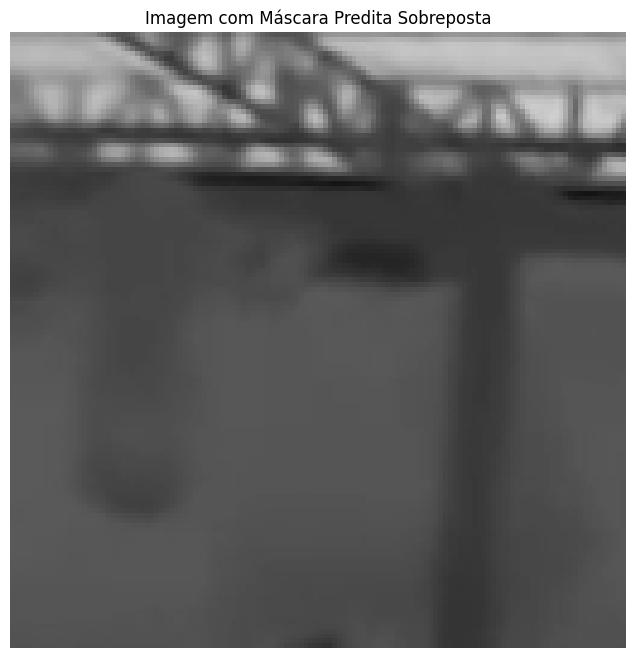

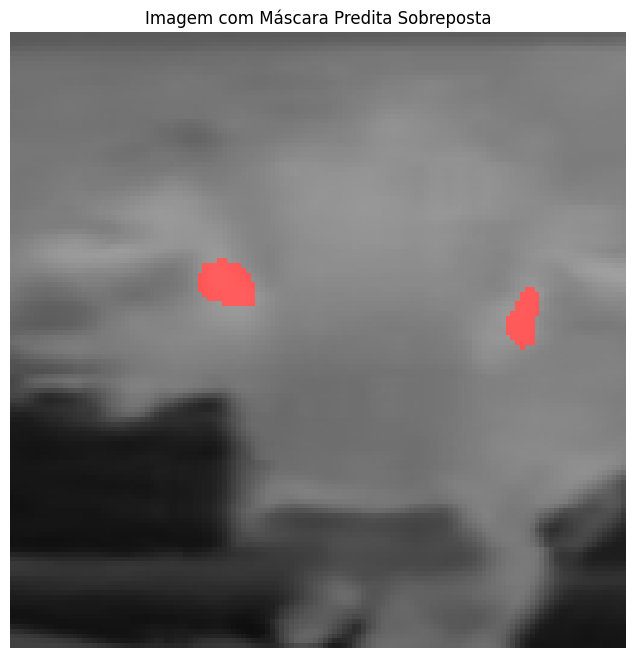

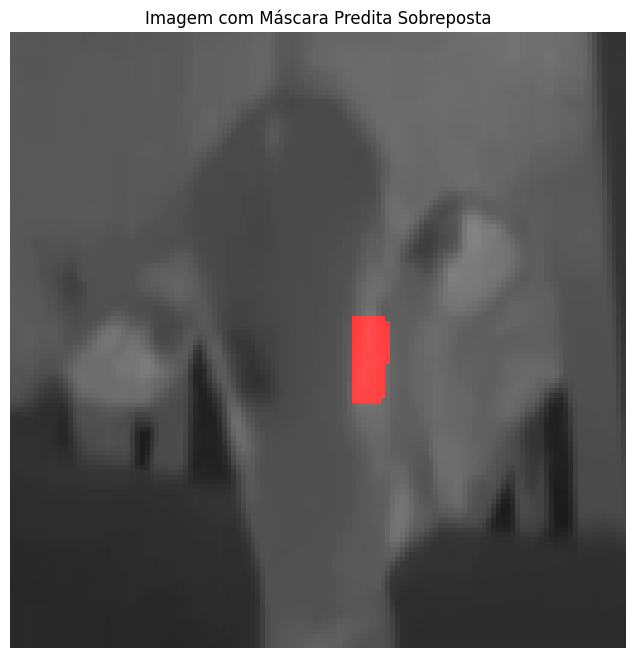

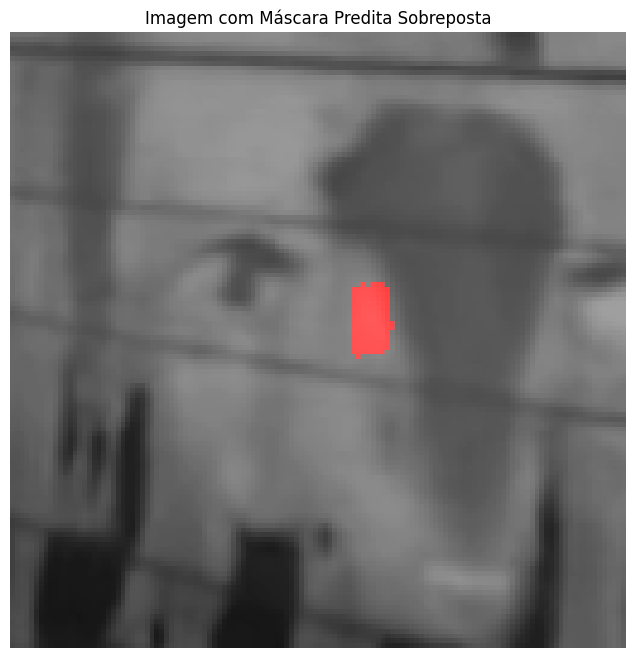

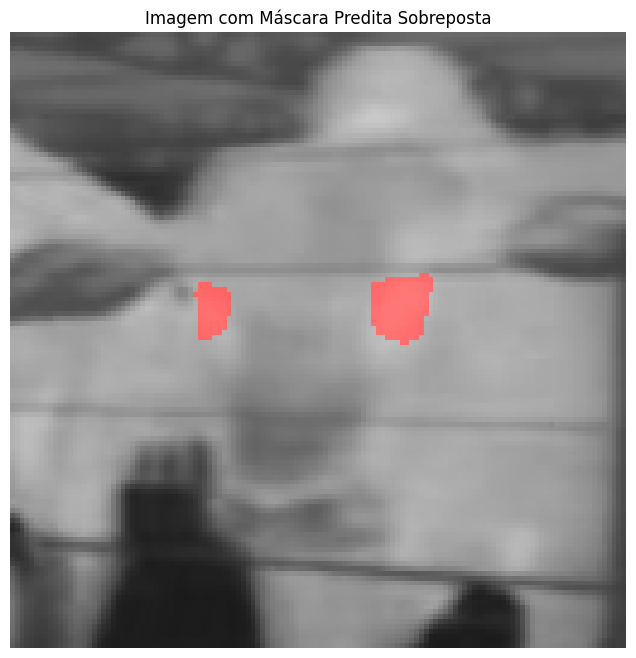

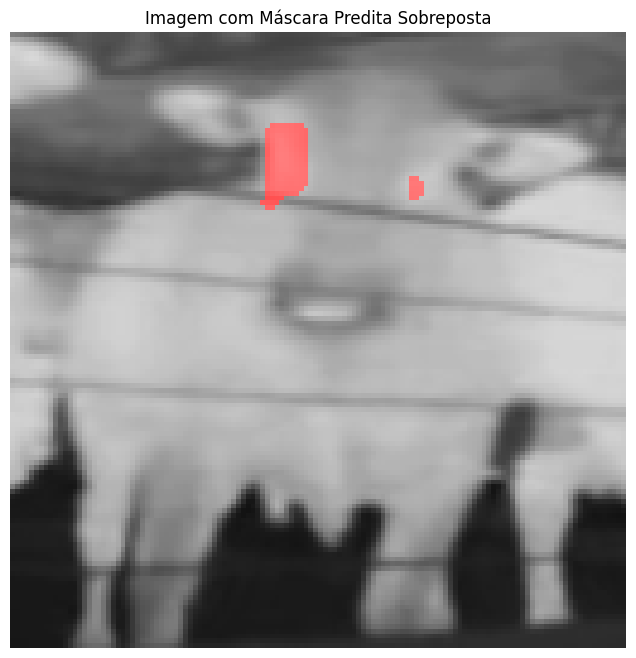

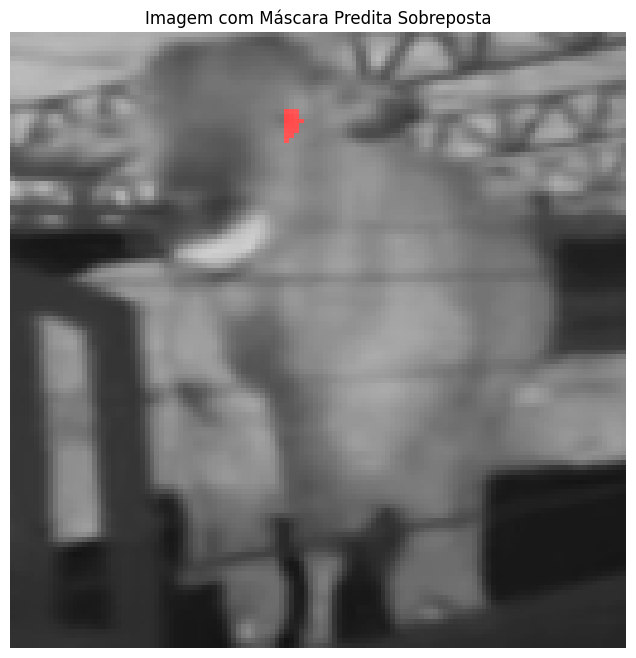

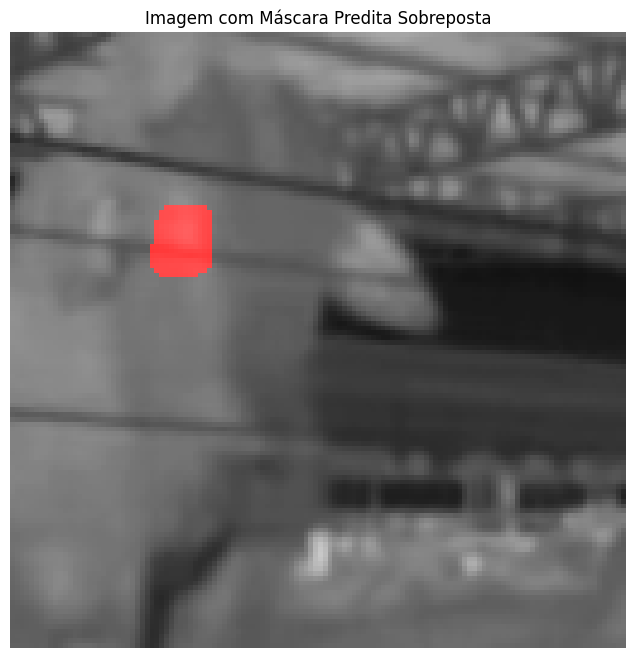

In [ ]:

def overlay_mask_on_image(image, mask, alpha=0.4):
    """
    Sobrepõe a máscara predita sobre a imagem original com transparência.
    """
    # Garantir que a máscara esteja no formato (128, 128, 1)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    # Redimensionar a máscara para ter 3 canais (RGB)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # Criar uma imagem vermelha do tamanho da máscara
    red_mask = np.zeros_like(image, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # Canal vermelho (R) é 255, os outros são 0

    # Aplicar a máscara vermelha nas áreas onde a máscara predita é branca (valor 1)
    overlay = np.where(mask_rgb == 1, red_mask, image)

    # Misturar a imagem original e a máscara sobreposta usando alpha para transparência
    output = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    return output

# Gerar predições no conjunto de validação
y_pred = model.predict(X_val)

for i in range(30,40):
  # Supondo que X_val[0] seja a imagem original e y_pred[0] seja a máscara predita
  image = X_val[i]  # A imagem original
  mask = (y_pred[i] > 0.5).astype(np.uint8)  # Converter a máscara predita para binária (0 ou 1)

  # Chamar a função para sobrepor a máscara
  overlay_result = overlay_mask_on_image(image, mask)

  # Exibir a imagem com a máscara sobreposta
  plt.figure(figsize=(8, 8))
  plt.imshow(overlay_result)
  plt.title('Imagem com Máscara Predita Sobreposta')
  plt.axis('off')
  plt.show()


### Medição de Tempo de Treinamento, Inferência e Cálculo de Métricas de Precisão, Recall e F1-score

Este código mede o tempo total de treinamento do modelo e o tempo médio de inferência por imagem no conjunto de validação. Além disso, ele calcula as métricas de avaliação: precisão, recall e F1-score. Essas métricas comparam as previsões do modelo com as máscaras reais do conjunto de validação, avaliando a qualidade do modelo na tarefa de segmentação. O tempo de treinamento é medido com um cronômetro, enquanto o tempo de inferência é calculado para cada imagem individualmente. Por fim, o código converte as previsões e os rótulos em binário para calcular as métricas de desempenho.



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Medir o tempo de treinamento
start_time = time.time()

training_time = time.time() - start_time
training_hours, training_minutes = divmod(training_time // 60, 60)
print(f"Tempo Total de Treinamento: {int(training_hours)} horas e {int(training_minutes)} minutos")

# Medir o tempo de inferência por imagem
start_time = time.time()
predictions = np.array([model.predict(np.expand_dims(img, axis=0)) for img in X_val])
inference_time = (time.time() - start_time) / len(X_val)
print(f"Tempo Médio de Inferência por Imagem: {inference_time:.4f} segundos")

# Calcular precisão, recall e F1-score
Y_val_binary = (Y_val > 0.5).astype(np.uint8)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Achando precisão, recall e F1-score para cada imagem
precision = precision_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
recall = recall_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
f1 = f1_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')

print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Tempo Total de Treinamento: 0 horas e 0 minutos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/

Salvando o modelo de segmentação

In [ ]:
model2.save('/content/drive/MyDrive/data/saved_model/modelo_segmentacao.keras')